In [19]:
import os, sys, random, warnings, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm, trange
from itertools import chain

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input, layers, callbacks, utils, optimizers

In [20]:
class config:
    im_width = 128
    im_height = 128
    im_chan = 1
    path_train = 'train/'
    path_test = 'test/'

# Data Exploration

In [21]:
! unzip -q ../input/tgs-salt-identification-challenge/train.zip -d train/
! unzip -q ../input/tgs-salt-identification-challenge/test.zip -d test/

replace train/images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace test/images/8cf16aa0f5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


a

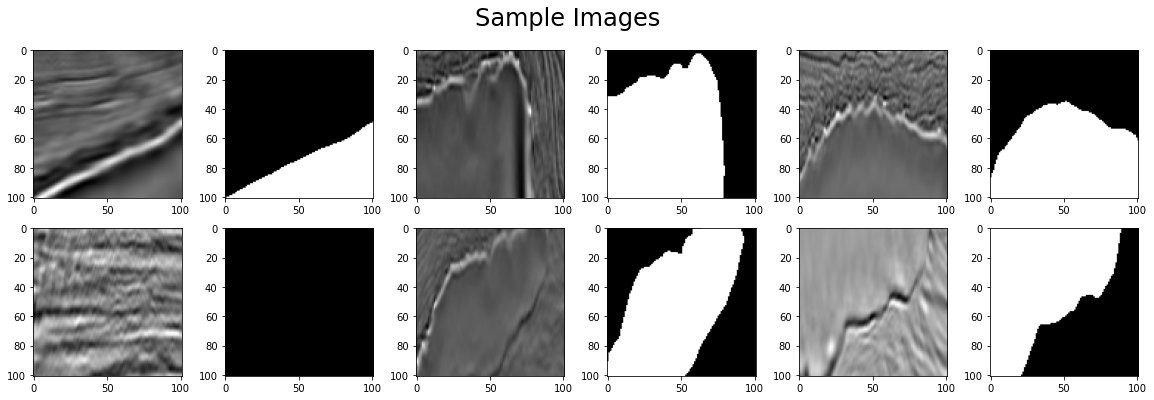

In [22]:
random.seed(19)
ids = random.choices(os.listdir('train/images'), k=6)
fig = plt.figure(figsize=(20,6))
for j, img_name in enumerate(ids):
    q = j+1
    
    img = load_img('train/images/' + img_name)
    img_mask = load_img('train/masks/' + img_name)
    
    plt.subplot(2, 6, q*2-1)
    plt.imshow(img)
    plt.subplot(2, 6, q*2)
    plt.imshow(img_mask)
fig.suptitle('Sample Images', fontsize=24);

In [23]:
train_ids = next(os.walk(config.path_train+"images"))[2]
test_ids = next(os.walk(config.path_test+"images"))[2]

In [24]:
X = np.zeros((len(train_ids), config.im_height, config.im_width, config.im_chan), dtype=np.uint8)
Y = np.zeros((len(train_ids), config.im_height, config.im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    x = img_to_array(load_img(config.path_train + '/images/' + id_, color_mode="grayscale"))
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = x
    mask = img_to_array(load_img(config.path_train + '/masks/' + id_, color_mode="grayscale"))
    Y[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Getting and resizing train images and masks ... 



Done!
X shape: (4000, 128, 128, 1)
Y shape: (4000, 128, 128, 1)


# Augmentation and Cross Validation

In [25]:
# Split the dataset into training, evaluation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)  # 80% training, 20% temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test


X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in Y], axis=0)

# X_train = np.append(X_train, [np.rot90(x, k=1) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=1) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=3) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=3) for x in Y], axis=0)

del X, Y

print('X train shape:', X_train.shape, 'X eval shape:', X_val.shape)
print('Y train shape:', Y_train.shape, 'Y eval shape:', Y_val.shape)


X train shape: (11200, 128, 128, 1) X eval shape: (400, 128, 128, 1)
Y train shape: (11200, 128, 128, 1) Y eval shape: (400, 128, 128, 1)


# Model Building

In [26]:
def BatchActivate(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = layers.Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [27]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    scaled = layers.Lambda(lambda x: x / 255) (input_layer)

    # 101 -> 50
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(scaled)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(DropoutRatio)(pool4)

    # Middle
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(DropoutRatio)(uconv4)
    
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])    
    uconv3 = layers.Dropout(DropoutRatio)(uconv3)
    
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
        
    uconv2 = layers.Dropout(DropoutRatio)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    
    uconv1 = layers.Dropout(DropoutRatio)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = layers.Dropout(DropoutRatio/2)(uconv1)
    #output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = layers.Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  layers.Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

input_layer = Input((config.im_height, config.im_width, config.im_chan))
output_layer = build_model(input_layer, 16)


model = models.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# model.summary()

In [28]:
es = callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-12, verbose=1)

results = model.fit(
    X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=25, callbacks=[es, rlp]
)

Epoch 1/25
1400/1400 [==============================] - 79s 56ms/step - loss: 0.3818 - acc: 0.8405 - val_loss: 0.4574 - val_acc: 0.8010
Epoch 2/25
1400/1400 [==============================] - 78s 55ms/step - loss: 0.3057 - acc: 0.8797 - val_loss: 0.3194 - val_acc: 0.8697
Epoch 3/25
1400/1400 [==============================] - 78s 55ms/step - loss: 0.2562 - acc: 0.9021 - val_loss: 0.2805 - val_acc: 0.8862
Epoch 4/25
1400/1400 [==============================] - 78s 55ms/step - loss: 0.2201 - acc: 0.9174 - val_loss: 0.2061 - val_acc: 0.9233
Epoch 5/25
1400/1400 [==============================] - 78s 55ms/step - loss: 0.2092 - acc: 0.9212 - val_loss: 0.9941 - val_acc: 0.7527
Epoch 6/25
1400/1400 [==============================] - 78s 55ms/step - loss: 0.2008 - acc: 0.9243 - val_loss: 0.1716 - val_acc: 0.9328
Epoch 7/25
1400/1400 [==============================] - 78s 56ms/step - loss: 0.1937 - acc: 0.9269 - val_loss: 0.1730 - val_acc: 0.9298
Epoch 8/25
1400/1400 [==========================

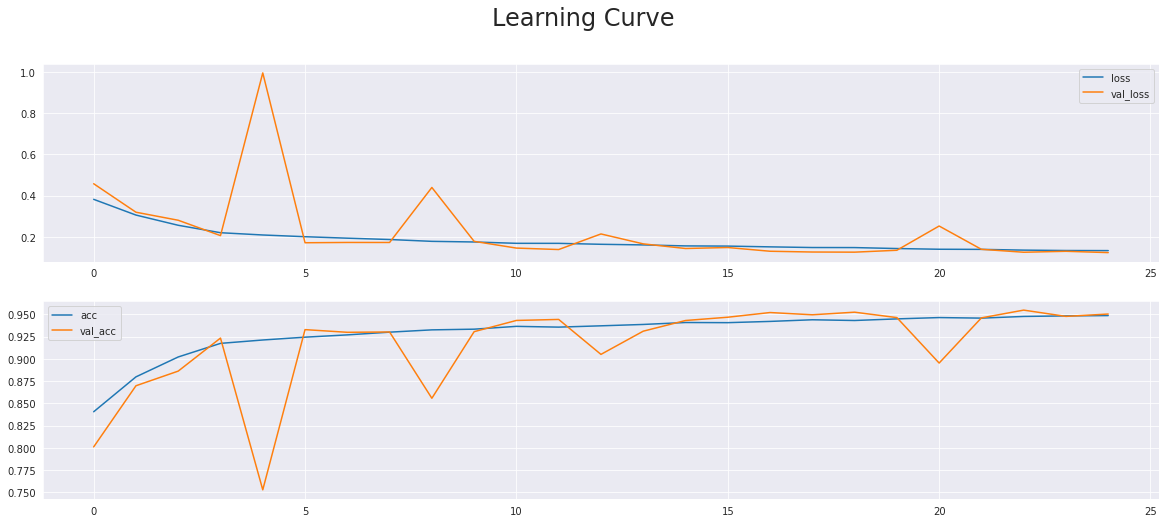

In [29]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
history = pd.DataFrame(results.history)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['acc', 'val_acc']].plot(ax=ax[1])
fig.suptitle('Learning Curve', fontsize=24);

# Scoring

# Model Evaluation

In [30]:
preds_test = model.predict(X_test, verbose=1)
preds_test_upsampled = []
for i in trange(len(preds_test)):
    preds_test_upsampled.append(resize(
        np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]),  mode='constant', preserve_range=True
    ))

13/13 [==============================] - 1s 53ms/step


NameError: name 'sizes_test' is not defined

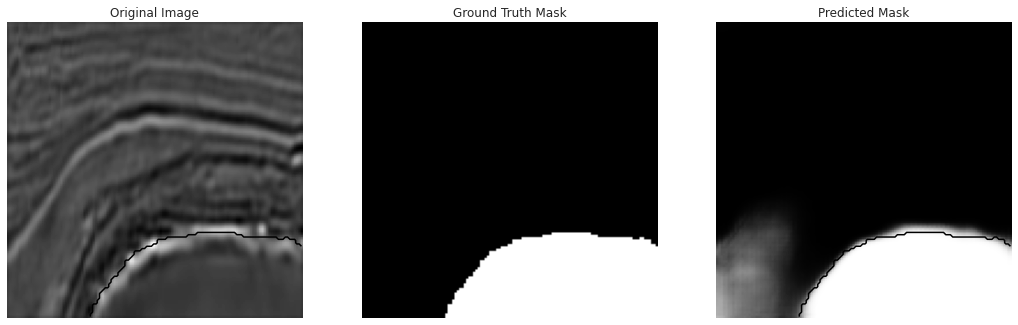

In [41]:
# Convert predictions to binary (if necessary)
preds_test_binary = (preds_test > 0.5).astype(int)
Y_test_binary = (Y_test > 0.5).astype(int)

import random
import matplotlib.pyplot as plt

# Define the plot_sample function
def plot_sample(X,y,preds):
    ix = random.randint(0, len(X-1))  # Randomly select an index
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original image
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Plot ground truth mask
    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Plot predicted mask
    ax[2].imshow(preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

# Call the plot_sample function with appropriate arguments
plot_sample(X_test, Y_test, preds_test)





In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions to binary values
preds_test_binary = (preds_test > 0.5).astype(int)
Y_test_binary = (Y_test > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_binary.flatten(), preds_test_binary.flatten())
precision = precision_score(Y_test_binary.flatten(), preds_test_binary.flatten())
recall = recall_score(Y_test_binary.flatten(), preds_test_binary.flatten())
f1 = f1_score(Y_test_binary.flatten(), preds_test_binary.flatten())

# Display evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))


Accuracy: 0.9327
Precision: 0.8695
Recall: 0.8834
F1-score: 0.8764


In [ ]:
# sub = pd.DataFrame.from_dict(pred_dict,orient='index')
# sub.index.names = ['id']
# sub.columns = ['rle_mask']
# sub.to_csv('submission.csv')

In [ ]:


# plt.show()
